# Goals and Pseudocode of Bandit Algorithms

## Goals:
input - arm chosen by the player (0 to k arms) <br>
objective - maximize reward which is determined by minimizing regret <br>
constraints - varies <br>
model - varies <br>

## Constants:
k - # of arms on the bandit <br>
numIterations - how many rounds the model is "trained" <br>

## Methods:
### Epsilon Greedy
```
initialize epsilon to some constant probability
for t = 1...numIterations
  prob = Randomly generate a probability from 0 to 1
  if prob < epsilon:
    pull a random arm
  else:
    pull the arm with the best experimental mean

```
### Thompson Sampling
```
start off with wide distributions for each arm
for t = 1...numIterations
    randomly choose a point on the beta distribution for each k-arm and pull the one with the largest calculated value
```

### Upper Confidence Bound
```
first k turns: initialize experimental means by pulling each arm once
for t = 1...numIterations
  for i = 1...k:
    calculate a(i, t) = q_values[i] + sqrt((2*ln(t))/arm_counts[i])
  pull arm i that maximizes experimental mean + a(i, t)

```

### UCB Pick and Compare (new)
```
first k turns: initialize experimental means by pulling each arm once
for t = 1...numIterations
  calculate a(random(k), t) = q_values[i] + sqrt((2*ln(t))/arm_counts[i])
  pull arm i that is max of previous arm and randomly calculated arm (cost efficient)
```

In [114]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline

In [115]:
# Function that graphs the average reward of an algorithm over time
# Also graphs a barchart to show the frequency at which particular arms are chosen

def plot_history(history):
    rewards = history["rewards"]
    average_rewards = history["average_rewards"]
    chosen_arms = history["arms"]
    cumulative_rewards = history["cumulative_rewards"]

    fig, axs = plt.subplots(3, figsize=[30, 30])
    
    axs[0].plot(cumulative_rewards, label = "cumulative rewards")
    axs[0].set_title("Rewards")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Rewards")
    
    axs[1].plot(average_rewards, label = "average rewards")
    axs[1].set_title("Average Rewards")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Reward")
    
    axs[2].bar([i for i in range(len(chosen_arms))], chosen_arms, label = "chosen arms")
    axs[2].set_title("Chosen Actions")
    axs[2].set_xlabel("Arm #")
    axs[2].set_ylabel("Number of times selected")  

In [116]:
# Initialize general environment to be used by all agents

class Env():
    def __init__(self, rewards, deviations):
        self.rewards = rewards
        self.deviations = deviations
        self.k = len(rewards)

    def choose_arm(self, arm):
        return np.random.normal(self.rewards[arm], self.deviations[arm])

In [117]:
nArms = 5000
# r = [1, 2, 3, 4, 5]
# d = [1, 1, 1, 1, 0]
# environment = Env(rewards=r, deviations=d)

environment = Env(rewards=np.random.randint(1, 50, nArms), deviations=np.random.randint(1, 10, nArms))

# x = np.random.randint(1, 100, 20)
# y = np.random.randint(1, 10, 20)
# environment2 = Env(rewards=x, deviations=y)
# for i in range(len(x)):
#     print(x[i], y[i])
#     print(environment2.choose_arm(i))

# Random Agent
This agent simply chooses random arms and pulls them

In [118]:
class RandomAgent():
    def __init__(self, env, max_iterations=2000):
        self.env = env
        self.iterations = max_iterations

    def act(self):
        start_time = datetime.datetime.now()
        
        arm_counts = np.zeros(self.env.k)
        rewards = []
        average_rewards = []
        cumulative_rewards = []

        for i in range(1, self.iterations + 1):
            arm = np.random.choice(self.env.k)
            reward = self.env.choose_arm(arm)

            arm_counts[arm] += 1
            rewards.append(reward)
            cumulative_rewards.append(sum(rewards))
            average_rewards.append(sum(rewards) / len(rewards))

        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds()*1000
                
        return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards,
               "cumulative_rewards": cumulative_rewards, "time": execution_time}

In [119]:
random_agent = RandomAgent(env=environment, max_iterations=2000)
RA_history = random_agent.act()
print(f"TOTAL REWARD : {sum(RA_history['rewards'])}")
print(f"TIME TAKEN (ms) : {RA_history['time']}")

TOTAL REWARD : 50992.036496809924
TIME TAKEN (ms) : 56.029


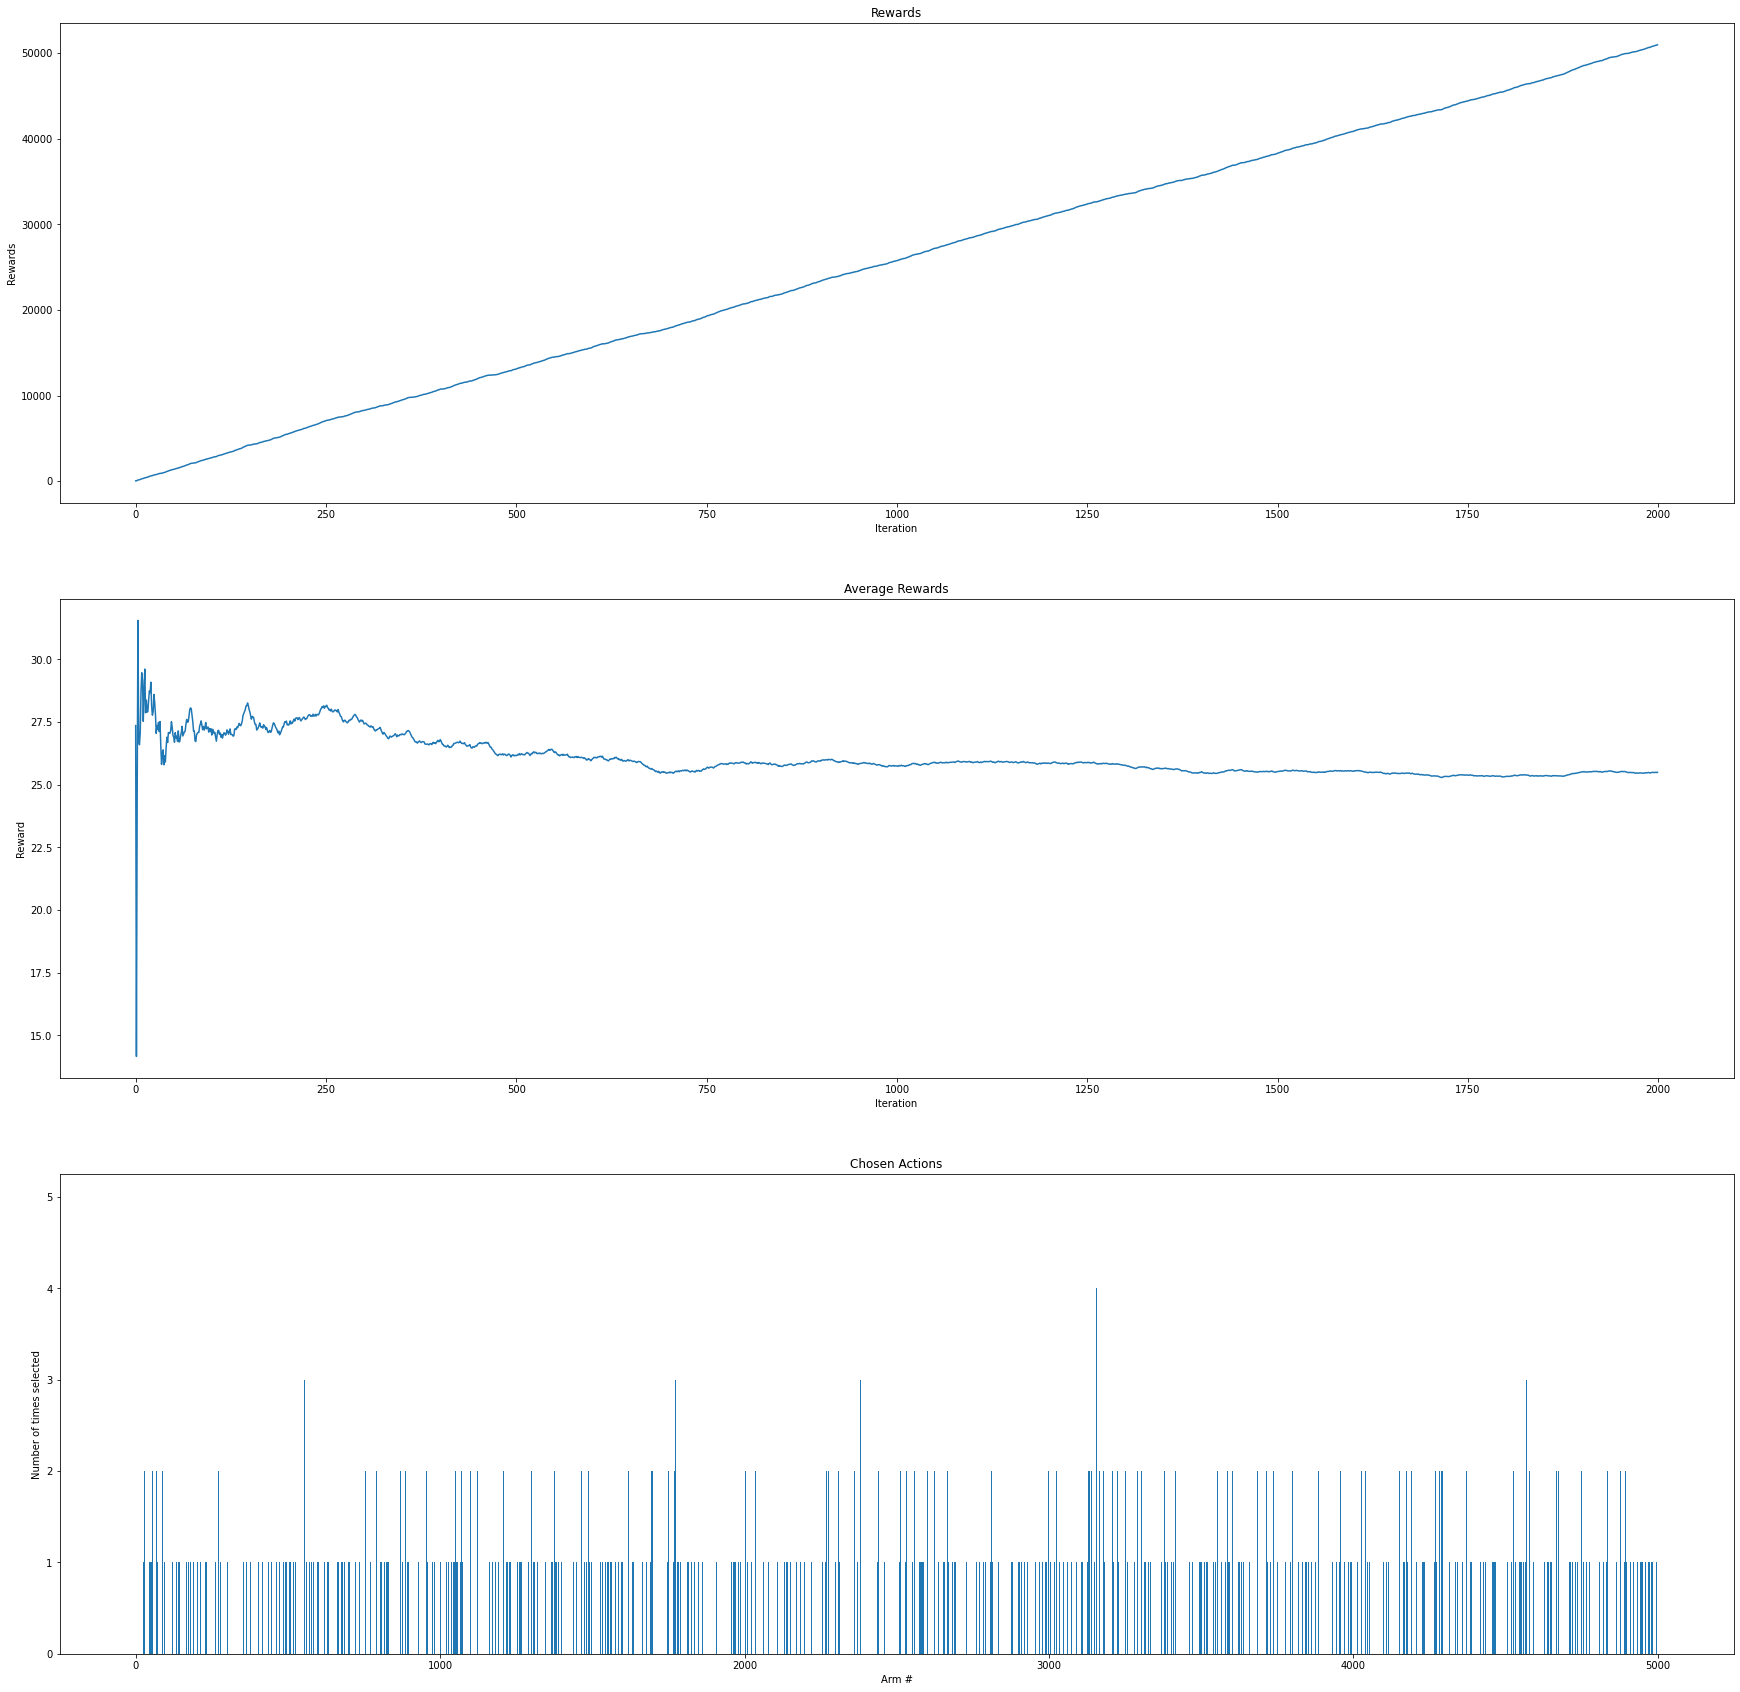

In [120]:
plot_history(RA_history)

# Thompson Sampling Agent

In [121]:
def draw_distributions(T, env, idx):
    for i in range(env.k):
        samps = np.random.normal(T.post_mu[i], T.post_sigma[i], 10000)
        sns.kdeplot(samps, shade=True)
    plt.title('Iteration %s'%(idx+1), fontsize=20)
#     plt.legend(['mu=%s'%(env.rewards[i]) for i in range(env.k)], fontsize=16)
    plt.xlim(-10,10)
    plt.xlabel('Average Satisfacton', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    
    plt.show()

In [122]:
class ThompsonSamplingAgent():
    def __init__(self, env):
        self.env = env
        
        self.prior_mu = np.zeros(self.env.k)
        self.prior_sigma = np.full(self.env.k, 1000.0)
        
        self.post_mu = np.zeros(self.env.k)
        self.post_sigma = np.full(self.env.k, 1000.0)
        
        self.n = np.zeros(env.k)
        self.sum_satisfaction = np.zeros(env.k)
        
    def get_mu_from_current_distribution(self, arm):
        return np.random.normal(self.post_mu[arm], self.post_sigma[arm])
    
    def update_current_distribution(self, arm):
        self.post_sigma[arm] = np.sqrt((1 / self.prior_sigma[arm]**2 + self.n[arm])**-1)        
        self.post_mu[arm] = (self.post_sigma[arm]**2) * (self.sum_satisfaction[arm])

In [128]:
def TS_act():
    start_time = datetime.datetime.now()
    
    T = ThompsonSamplingAgent(environment)
    rewards = []
    average_rewards = []
    cumulative_rewards = []

    for i in range(2000):
    #     if environment.k <= 10 and (i < 10 or (i < 100 and (i+1) % 10 == 0) or ((i+1) % 100 == 0)):
    #         draw_distributions(T, environment, i)

        #get a sample from each posterior
        post_samps = [T.get_mu_from_current_distribution(i) for i in range(environment.k)]

        #index of distribution with highest satisfaction
        chosen_idx = post_samps.index(max(post_samps))

        #get a new sample from that distribution
        s = T.env.choose_arm(chosen_idx)
        T.n[chosen_idx] += 1
        T.sum_satisfaction[chosen_idx] += s

        #update other values
        rewards.append(s)
        average_rewards.append(sum(rewards)/len(rewards))
        cumulative_rewards.append(sum(rewards))

        #update that distributions posterior
        T.update_current_distribution(chosen_idx)

        
    end_time = datetime.datetime.now()
    time_diff = (end_time - start_time)
    execution_time = time_diff.total_seconds()*1000
                
    return {"arms" : T.n, "rewards": rewards, "average_rewards": average_rewards,
                    "cumulative_rewards": cumulative_rewards, "time": execution_time}

In [130]:
TS_history = TS_act()
print(f"TOTAL REWARD : {sum(TS_history['rewards'])}")
print(f"TIME TAKEN (ms) : {TS_history['time']}")

TOTAL REWARD : 50340.40538176002
TIME TAKEN (ms) : 23712.116


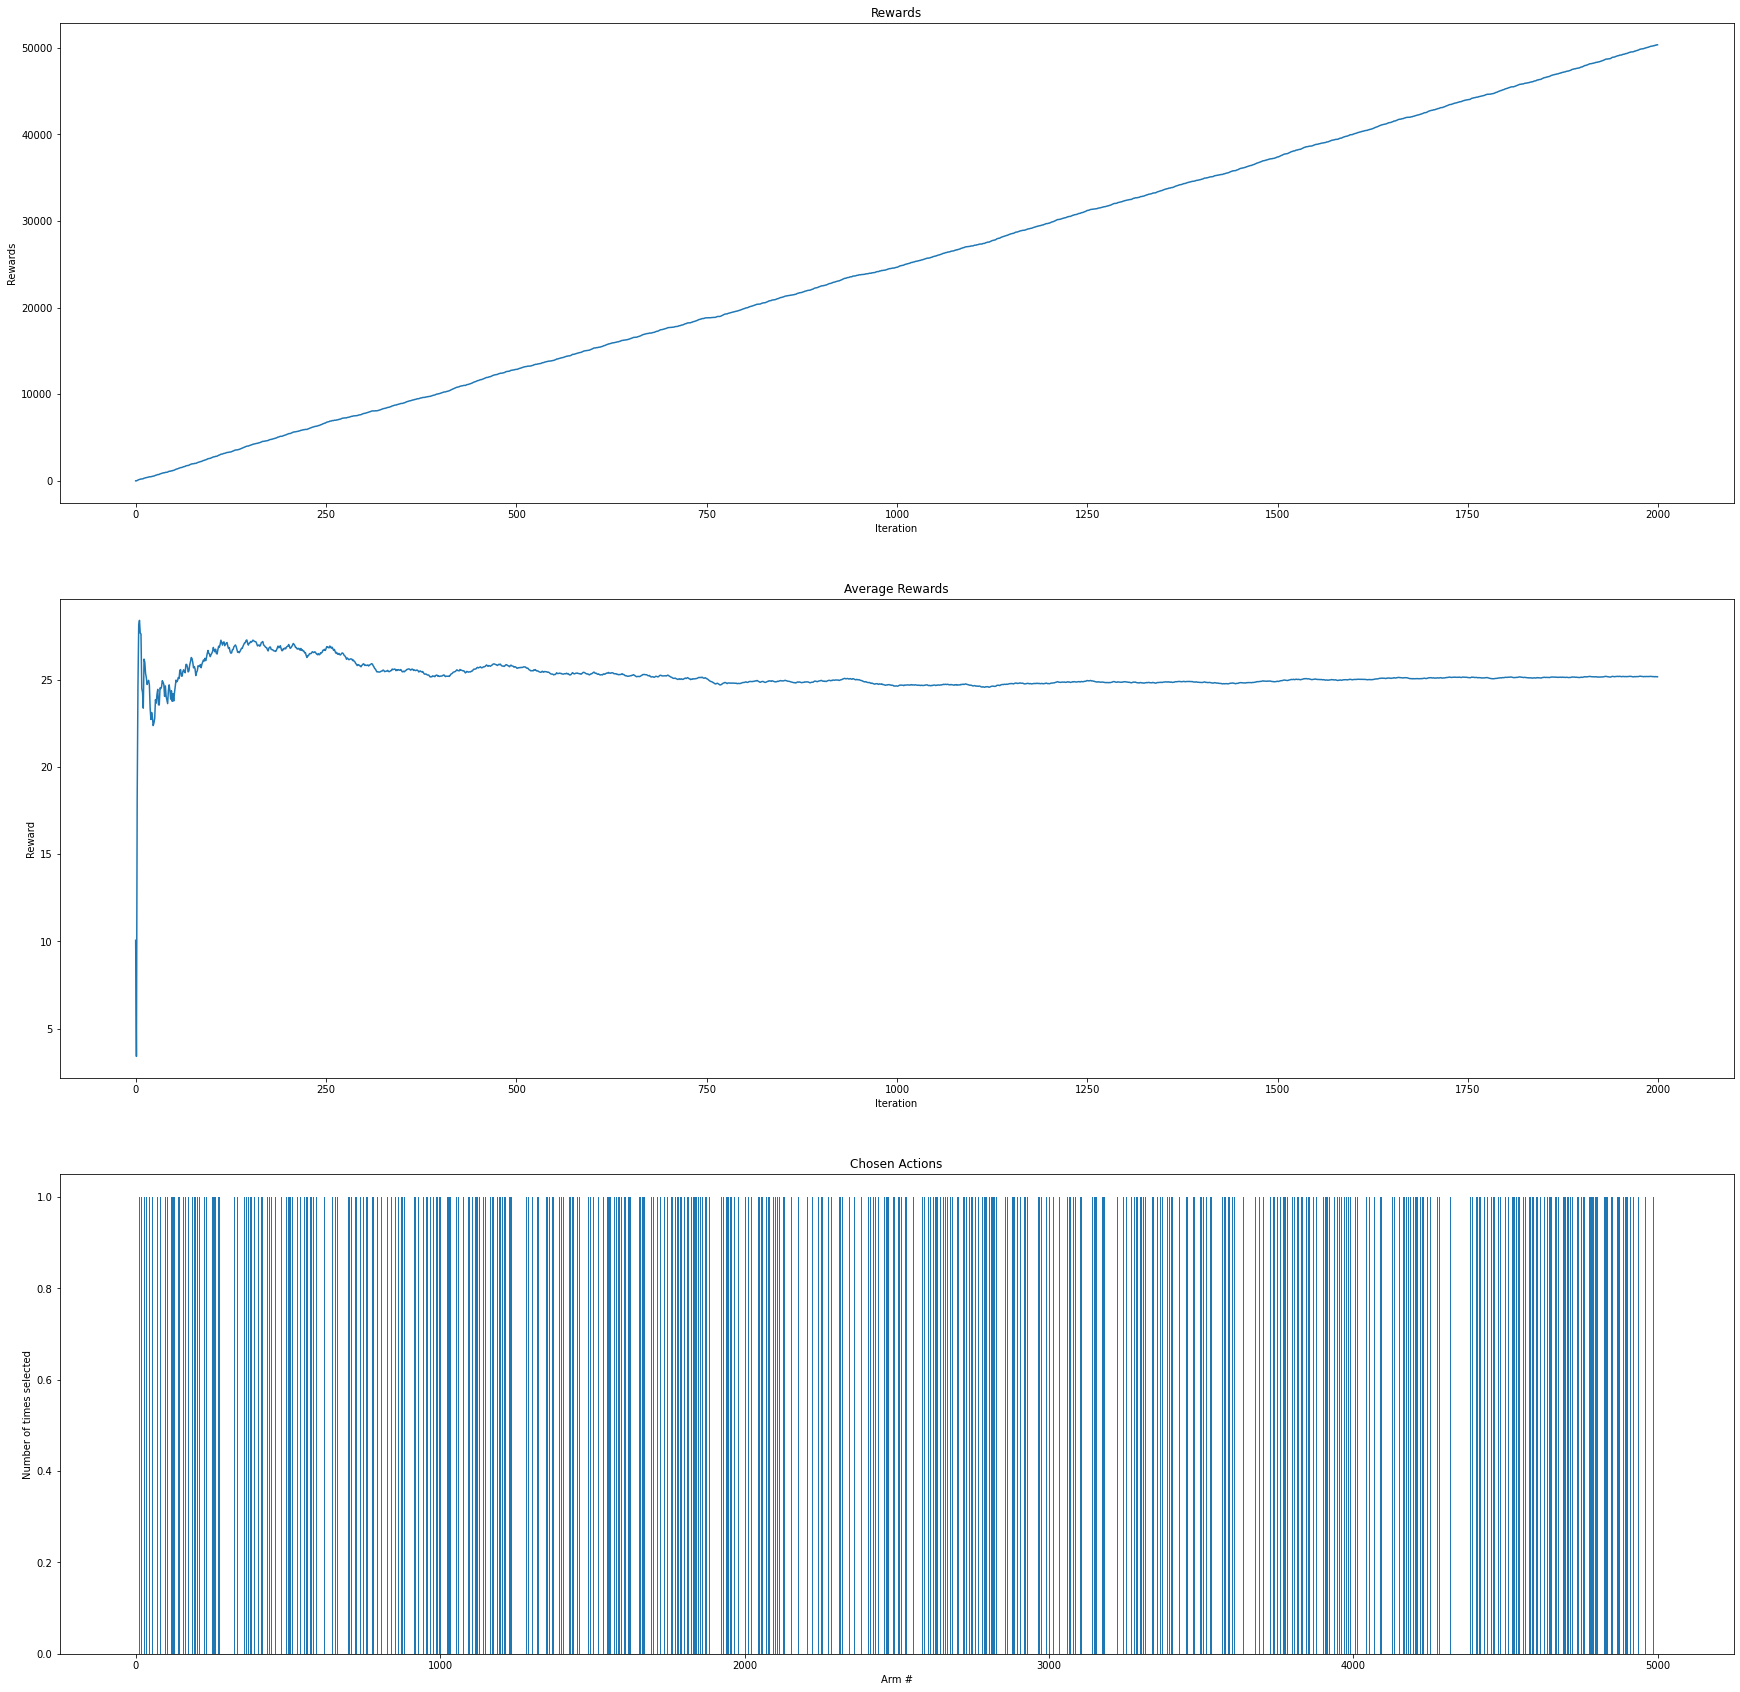

In [131]:
plot_history(TS_history)

# Epsilon Greedy Agent

In [132]:
class EpsilonGreedyAgent():
    def __init__(self, env, max_iterations=2000, epsilon=0.1):
        self.env = env
        self.iterations = max_iterations
        self.epsilon = epsilon

    def act(self):
        start_time = datetime.datetime.now()
        
        q_values = np.zeros(self.env.k)
        arm_rewards = np.zeros(self.env.k)
        arm_counts = np.zeros(self.env.k)

        rewards = []
        average_rewards = []
        cumulative_rewards = []

        for i in range(1, self.iterations + 1):
            arm = np.random.randint(self.env.k) if np.random.random() < self.epsilon else np.argmax(q_values)
            reward = self.env.choose_arm(arm)

            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

            cumulative_rewards.append(sum(rewards))
            rewards.append(reward)
            average_rewards.append(sum(rewards)/len(rewards))

        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds()*1000
                
        return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards,
               "cumulative_rewards": cumulative_rewards, "time": execution_time}

In [133]:
epsilon_greedy_agent = EpsilonGreedyAgent(env=environment, max_iterations=2000, epsilon=0.1)
EG_history = epsilon_greedy_agent.act()
print(f"TOTAL REWARD : {sum(EG_history['rewards'])}")
print(f"TIME TAKEN (ms) : {EG_history['time']}")

TOTAL REWARD : 89378.23349493151
TIME TAKEN (ms) : 37.028999999999996


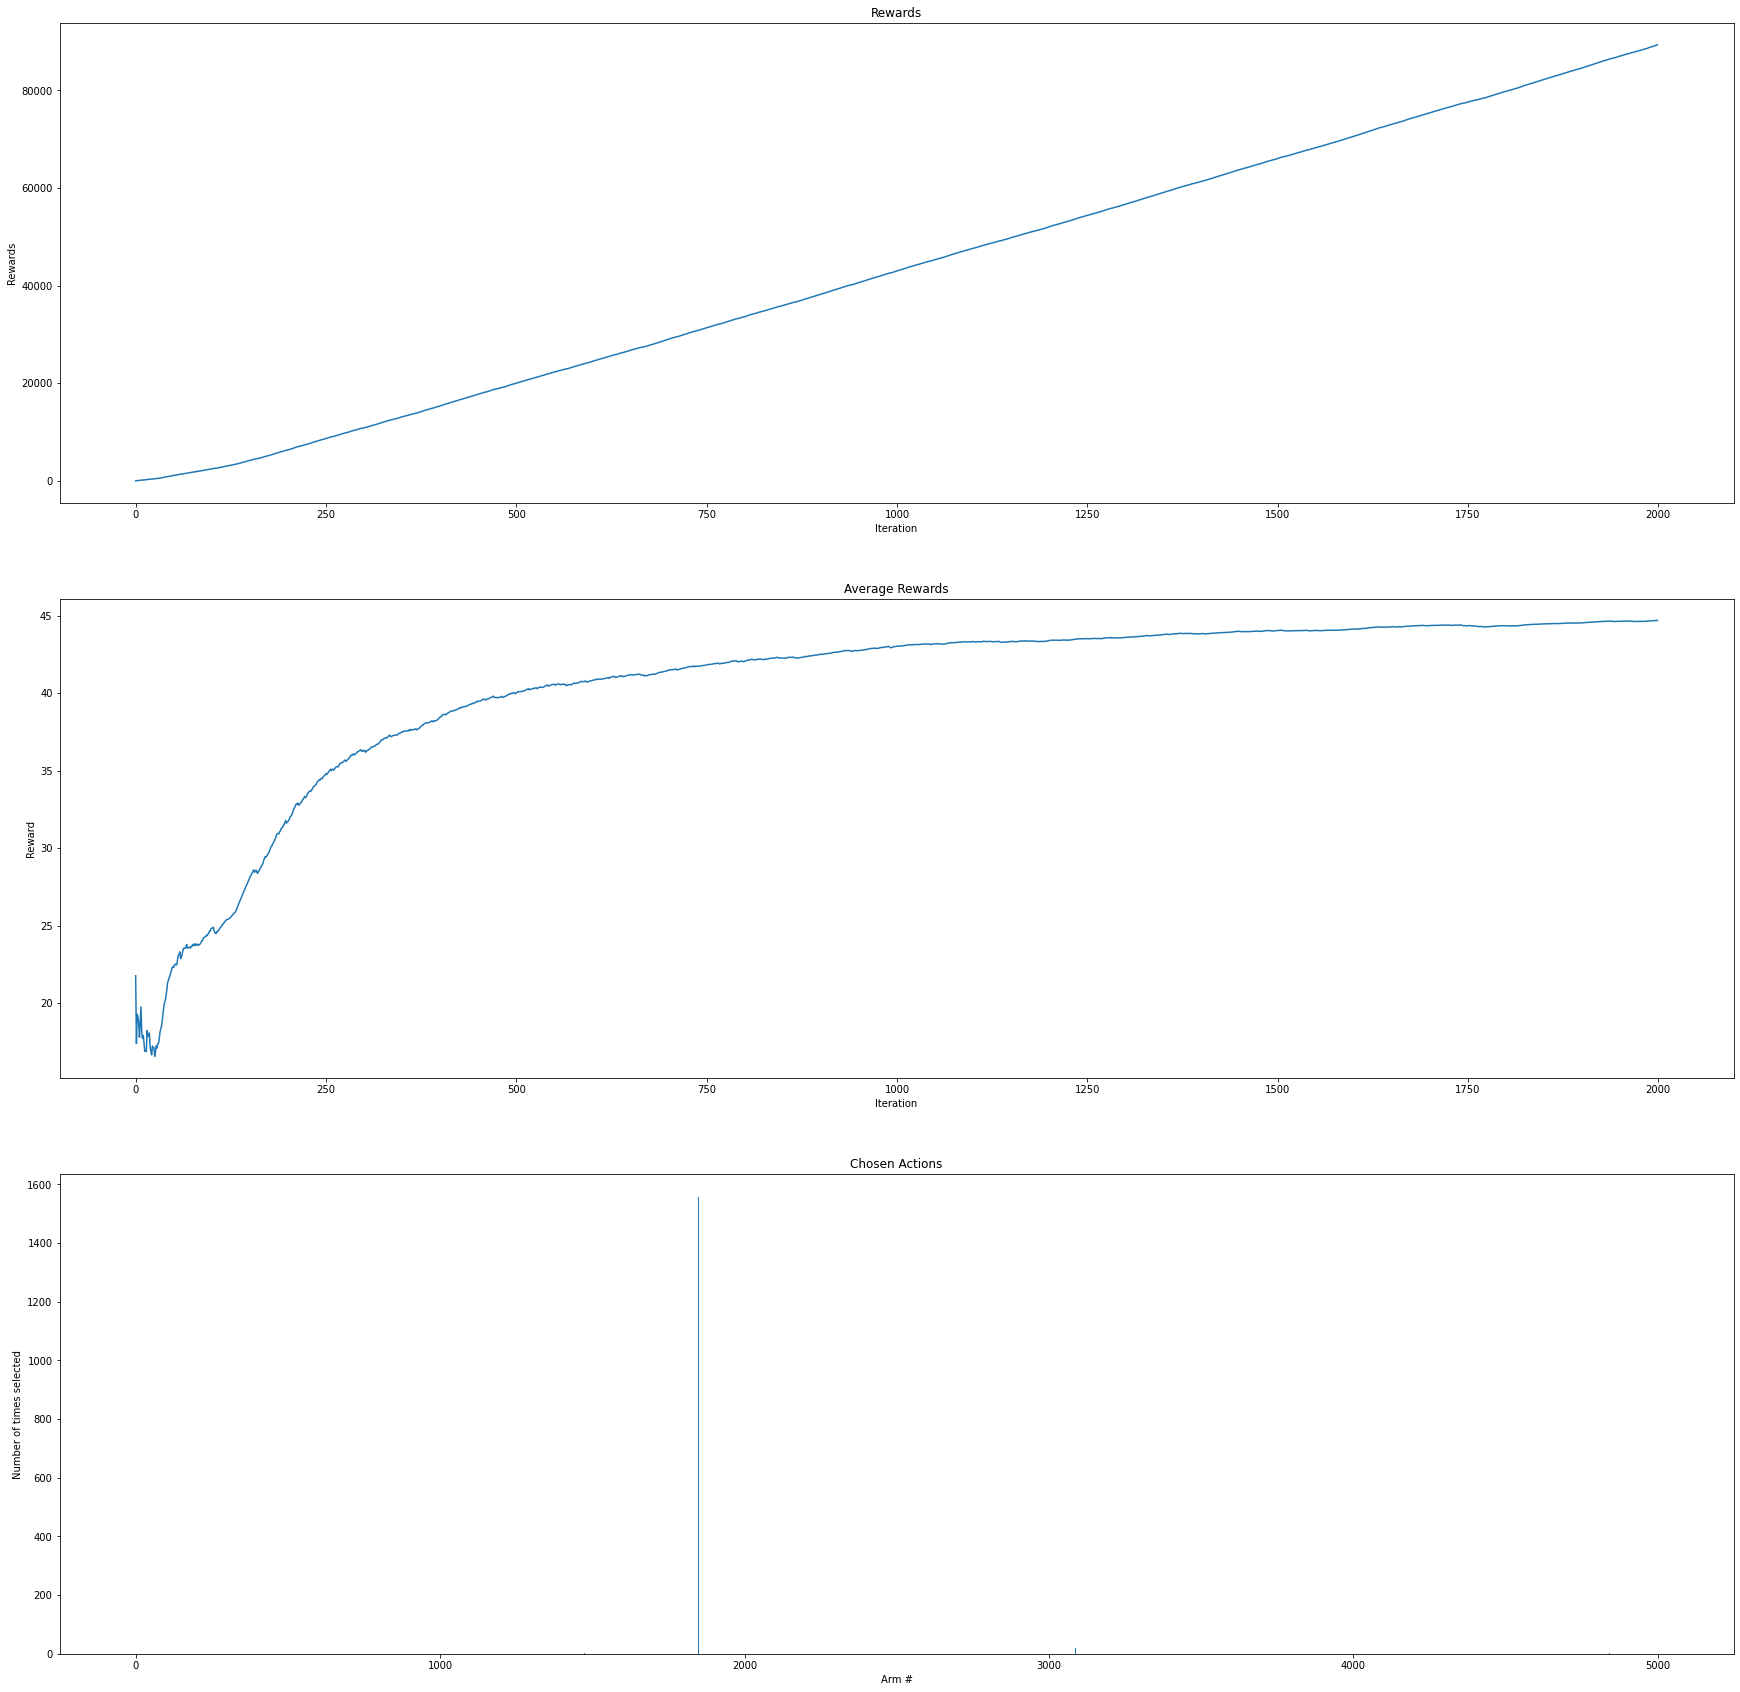

In [134]:
plot_history(EG_history)

# Upper Confidence Bound (UCB) Agent

In [135]:
class UpperConfidenceBoundAgent():
    def __init__(self, env, max_iterations=2000):
        self.env = env
        self.iterations = max_iterations
  
    def act(self):
        start_time = datetime.datetime.now()
        
        q_values = np.zeros(self.env.k)
        arm_rewards = np.zeros(self.env.k)
        arm_counts = np.zeros(self.env.k)

        rewards = []
        average_rewards = []
        cumulative_rewards = []

        #traverse every arm once
        for arm in range(self.env.k):
            reward = self.env.choose_arm(arm)

            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

        for i in range(1, self.iterations + 1):
            arm = 0
            cur = 0
            # finds action where quantity u + hoffdings-constant is maximized
            for a in range(self.env.k):
                UCB = q_values[a] + np.sqrt((2*np.log(i))/arm_counts[a])
                if UCB > cur:
                    cur = UCB
                    arm = a

            reward = self.env.choose_arm(arm)

            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

            cumulative_rewards.append(sum(rewards))
            rewards.append(reward)
            average_rewards.append(sum(rewards)/len(rewards))

        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds()*1000
                
        return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards,
               "cumulative_rewards": cumulative_rewards, "time": execution_time}

In [136]:
UCB_agent = UpperConfidenceBoundAgent(env=environment, max_iterations=2000)
UCB_history = UCB_agent.act()
print(f"TOTAL REWARD : {sum(UCB_history['rewards'])}")
print(f"TIME TAKEN (ms) : {UCB_history['time']}")

TOTAL REWARD : 94264.74720768057
TIME TAKEN (ms) : 23181.384000000002


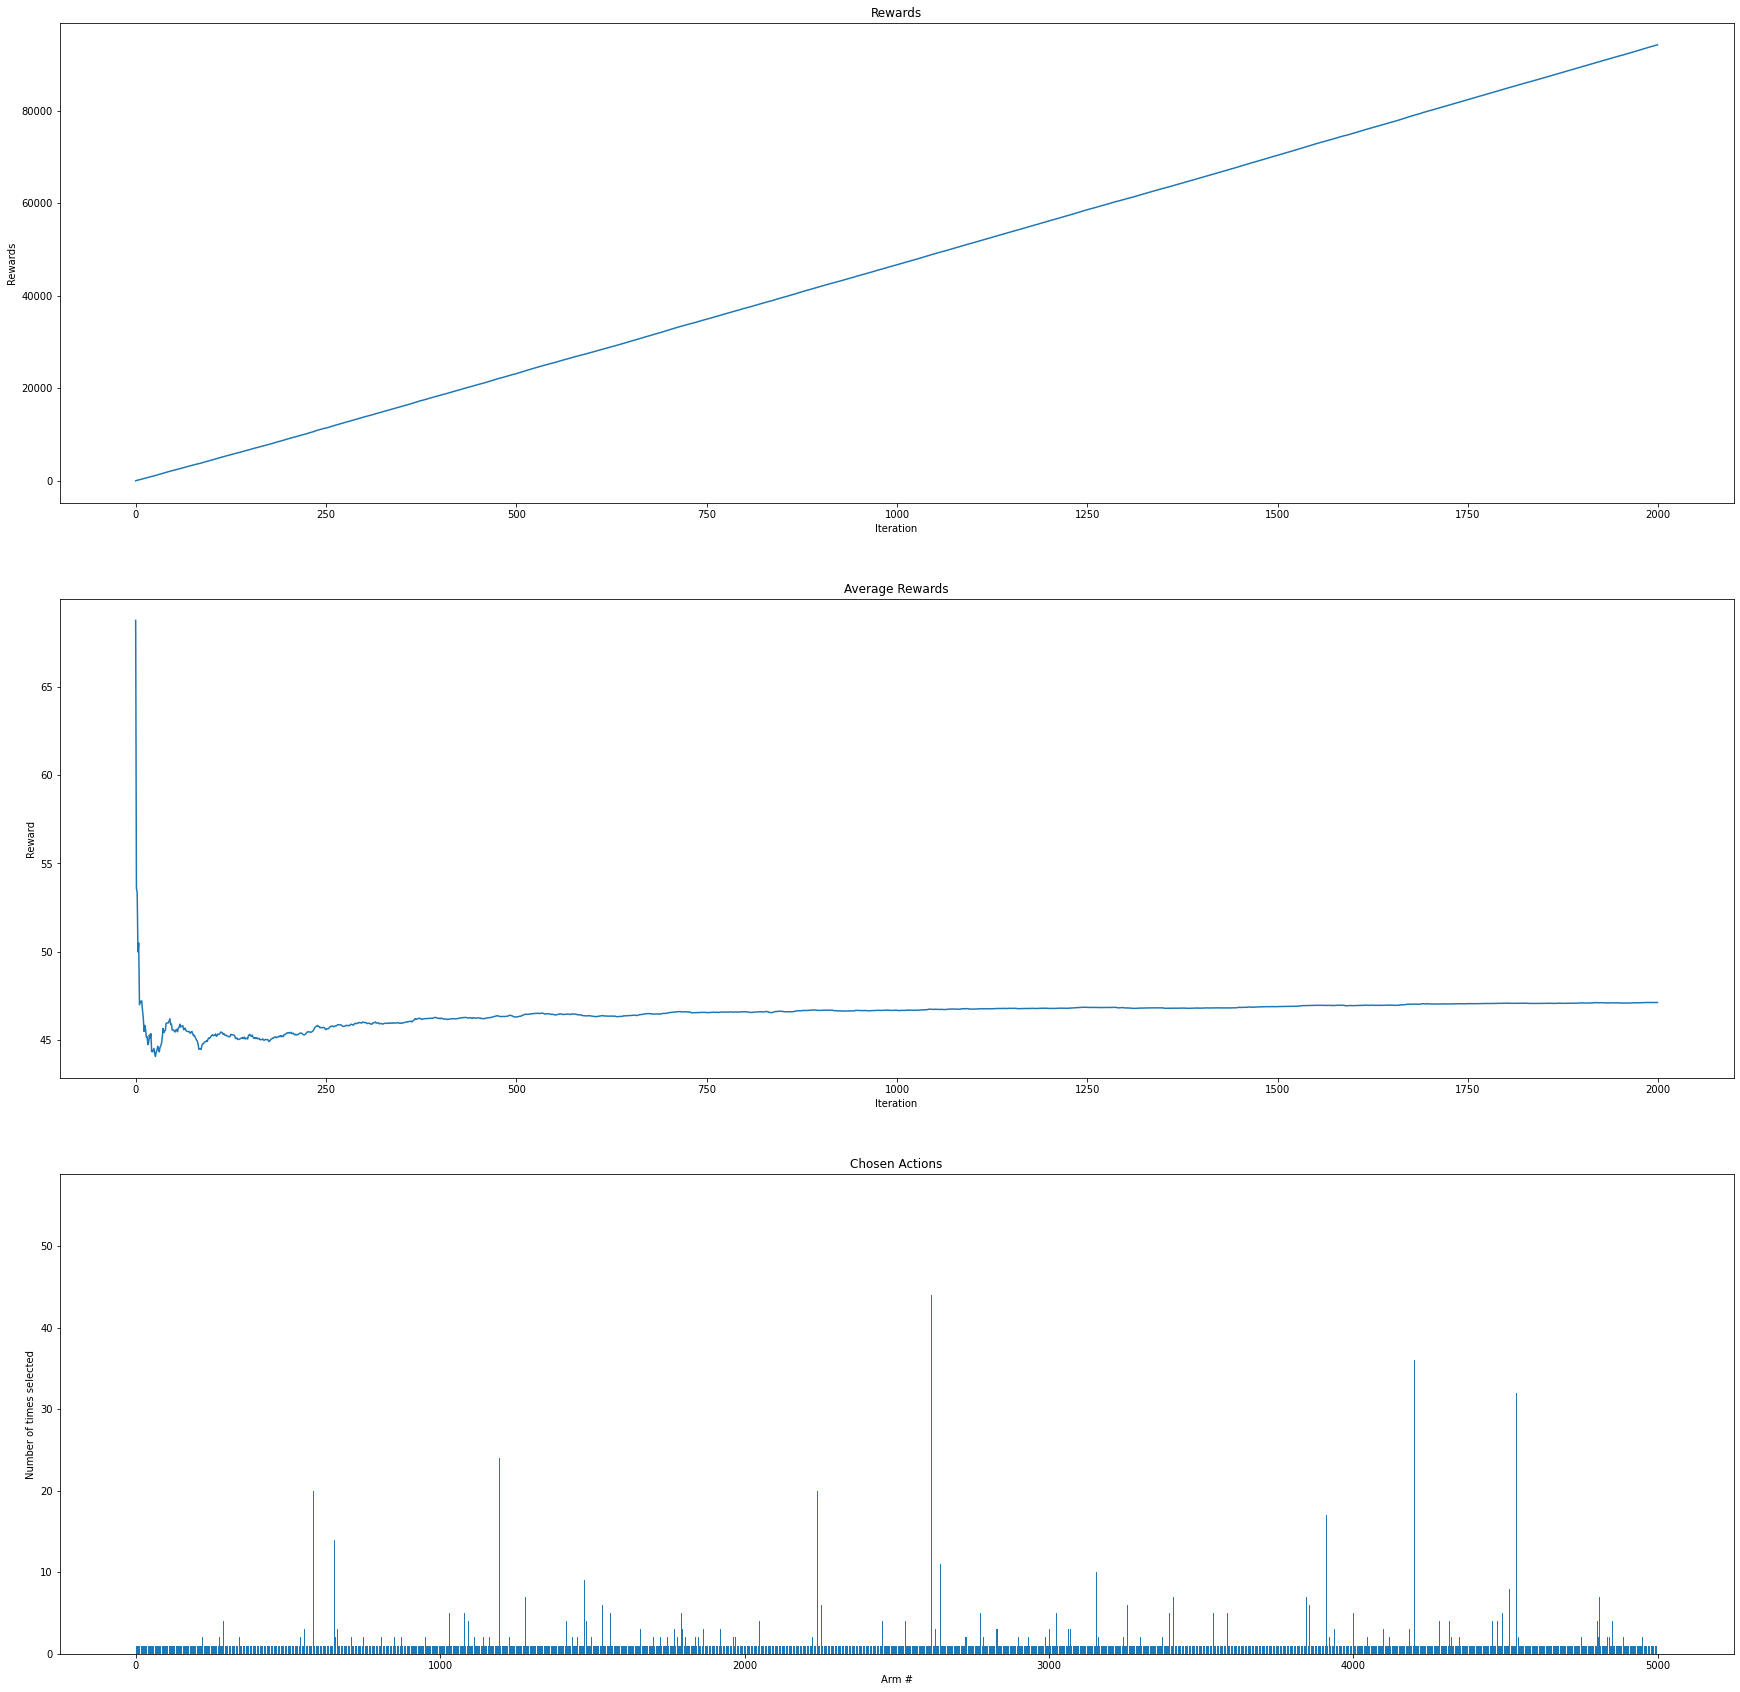

In [137]:
plot_history(UCB_history)

# UCB Pick and Compare Method

In [138]:
class UCB_PickAndCompareAgent():
    def __init__(self, env, max_iterations=2000):
        self.env = env
        self.iterations = max_iterations
  
    def act(self):
        start_time = datetime.datetime.now()
        
        q_values = np.zeros(self.env.k)
        arm_rewards = np.zeros(self.env.k)
        arm_counts = np.zeros(self.env.k)

        rewards = []
        average_rewards = []
        cumulative_rewards = []

        #traverse every arm once
        for arm in range(self.env.k):
            reward = self.env.choose_arm(arm)

            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

        # set default value for previous arm
        previous_arm = 0
        for i in range(1, self.iterations + 1):
            UCB_previous = q_values[previous_arm] + np.sqrt((2*np.log(i))/arm_counts[previous_arm])
            
            compare_arm = np.random.choice(self.env.k)
            UCB_compare = q_values[compare_arm] + np.sqrt((2*np.log(i))/arm_counts[compare_arm])

            arm = (previous_arm if UCB_previous > UCB_compare else compare_arm)
            reward = self.env.choose_arm(arm)

            previous_arm = arm
            
            arm_rewards[arm] += reward
            arm_counts[arm] += 1
            q_values[arm] = arm_rewards[arm]/arm_counts[arm]

            cumulative_rewards.append(sum(rewards))
            rewards.append(reward)
            average_rewards.append(sum(rewards)/len(rewards))

        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds()*1000
                
        return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards,
               "cumulative_rewards": cumulative_rewards, "time": execution_time}

In [139]:
UCB_PC_agent = UCB_PickAndCompareAgent(env=environment, max_iterations=2000)
UCB_PC_history = UCB_PC_agent.act()
print(f"TOTAL REWARD : {sum(UCB_PC_history['rewards'])}")
print(f"TIME TAKEN (ms) : {UCB_PC_history['time']}")

0
0
4657
4657
4657
4657
4657
3076
3076
3076
3076
3076
4021
4021
4021
4021
415
415
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
1651
584
584
584
584
584
584
584
584
584
584
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
3966
2958
2958
2958
2958
2958
2958
685
685
685
685
685
2632
2632
177
177
177
177
795
795
795
795
795
795
795
795
491
491
491
491
491
491
491
491
491
491
491
491
491
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
1132
3927
3927
3927
3927
3927
3927
3927
3927
3927
3927
3927
3927
905
905
905
905
905
905
905
905
905
2217
2217
2217
2217
2217
4868
1037
1560
1560
1560
1560
1560
1560
1560
1560
1560
1560
1560
1560
1560
1560
1560
1560
1560
1560
2389
2389
2389
2389
2389
2389
2389
973
973
973
973
973
973
973
973
973
973
973
4789
4789
4789
4789
4789
4789
4789
4789
4789
4789
4259
4259
4259
4259
4259
4555
455

3653
3653
3653
3653
3653
3653
3653
3653
3653
3653
3653
3217
3217
3217
3217
3217
3217
3217
3217
3217
3217
TOTAL REWARD : 92707.8692729849
TIME TAKEN (ms) : 224.956


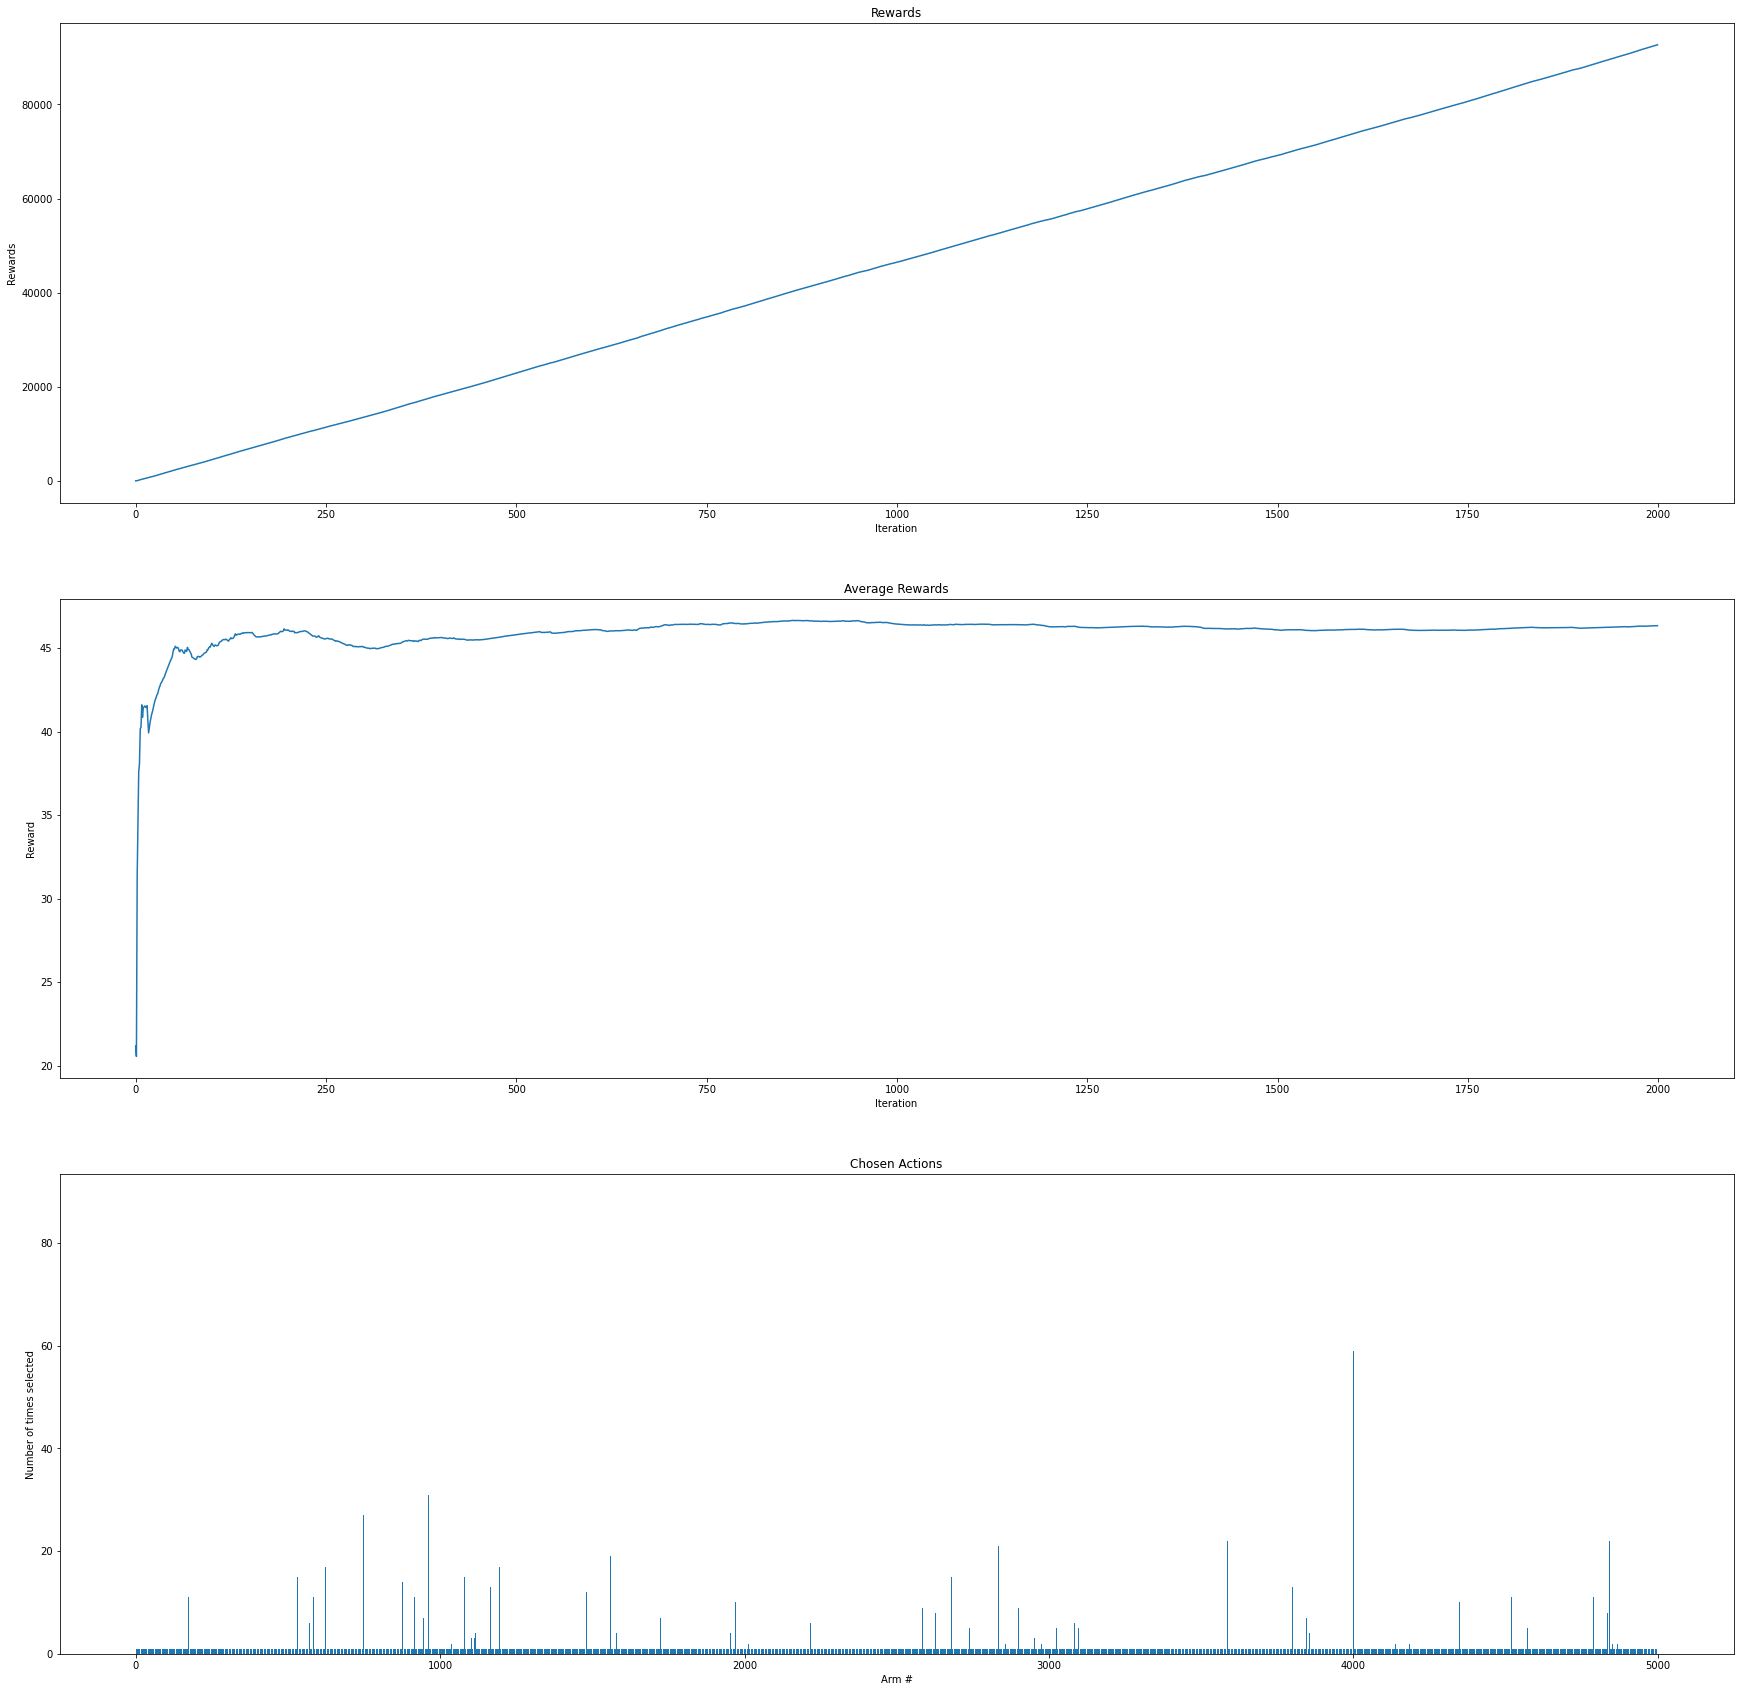

In [140]:
plot_history(UCB_PC_history)